## Tasks & Data
#### Tasks

1. Reproduce the ad impressions plot.
2. Find the reason for the increase of advertising impressions and explain what happened.
3. \*Suggest a way that would help to automatically detect abnormal changes in metrics on advertising statistics charts

#### Data description:

- `time` — time of users' interaction with advertising in the UnixTime format;
- `event` — type of impression (click — clicked on ad, view — viewed, report — reported an ad);
- `ad_cost_type` — type of ad payment (CPM — cost per 1000 views, CPC — cost per click);
- `has_video` — ad has a video (0 — no, 1 — yes);
- `agency_union_id` — id of the advertising agency (if the ad account belongs to an individual, then the value is set to 'no_agency');
- `client_union_id` — ad client id;
- `campaign_union_id` — ad campaign id;
- `ad_id` — ad id;
- `platform` — the platform from which the user interacted with the ad (web — web, mvk — mobile version, iphone — iOS app, android — Android app, wphone — Windows Phone app).

## Preparation

In [122]:
import re
import numpy as np 
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [123]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv('test_data.csv', parse_dates=['date'], date_parser=dateparse)
df['date_time'] = pd.to_datetime(df['time'], unit='s')

In [124]:
df = df.sort_values(by='time').reset_index(drop=True)
# set time column as index to use .resample() further 
df = df.set_index('date_time')
df.head(3)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
date_time,,,,,,,,,,
2019-04-01 00:00:48,1.554077e+09,click,CPM,0,no_agency,client_31916,campaign_44282,ad_44282,web,2019-04-01
2019-04-01 00:01:03,1.554077e+09,view,CPC,0,no_agency,client_51,campaign_8339,ad_8339,android,2019-04-01
2019-04-01 00:01:09,1.554077e+09,view,CPM,0,no_agency,client_108,campaign_10356,ad_10356,android,2019-04-01


## task 1: reproduce the ad impressions plot.


In [125]:
# set plotting parameters
sns.set(rc={'figure.figsize':(19, 7), 'axes.titlesize':16, 'axes.labelsize':14, 'xtick.labelsize':12, 
            'ytick.labelsize':12,'axes.titlepad': 30, 
           })

In [126]:
def daily_plot(data, group_var=None, group_title=None, ax=None, color='#45678f'):
    """Plots daily events.
    x – days, y – number of events.
    Also can group by another variable (e.g. platform)
    
    Parameters
    ---------
    data: pandas DataFrame
        DataFrame.
    group_var: str, optional
        Grouping variable.
    group_title: str, optional
        Legend title.
    ax: axis, optional
        Axis object if it's already present (useful for plotting several graphs at once).
    color: str, optional
        Line color.
    """
    if ax is None:
        fig, ax = plt.subplots()    
        
    # aggregate the data
    if group_var:
        data_TMP = data.groupby(['date', group_var]).size().reset_index(name='counts')
        for val in data_TMP[group_var].unique().tolist():
            ax.plot(data_TMP[data_TMP[group_var] == val].date, data_TMP[data_TMP[group_var] == val].counts, 
                    label=val, linewidth=3, markersize=6, marker='o')
        ax.legend(data_TMP[group_var].unique().tolist(), title=group_title, loc='best', framealpha=0)
    else:
        data_TMP = data.groupby(['date']).size().reset_index(name='counts')  # df.resample(rule='D').count()
        ax.plot(data_TMP.date, data_TMP.counts, color=color,
                linewidth=3, markersize=6, marker='o')
        
    ax.set(xlabel='Days', ylabel='Number of ad impressions', 
           title='Distribution of ad impressions')
    
    # customize the plot: set formatters & grid
    ax.set_frame_on(False) # sns.despine() 
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: '{:,g}k'.format(y/1000)))
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))
    
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    
    #return fig, ax

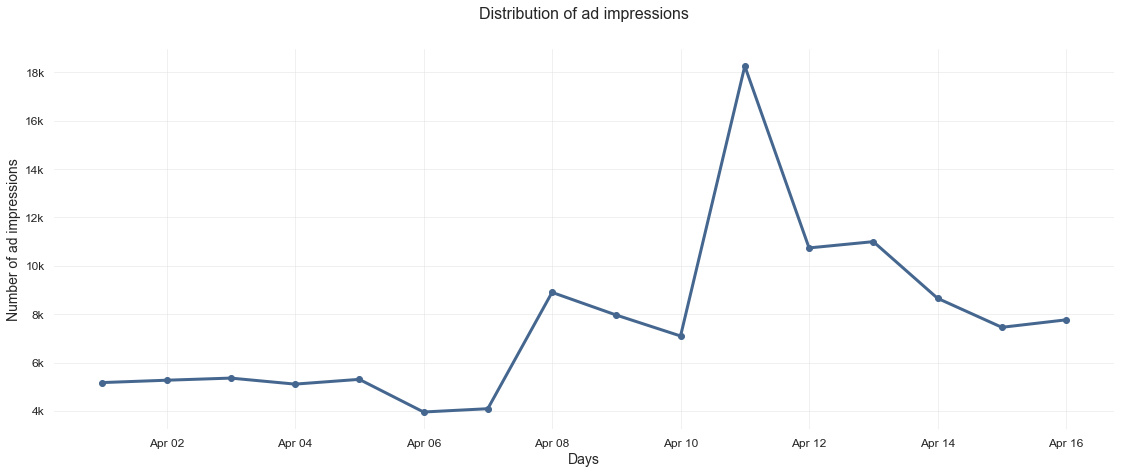

In [127]:
daily_plot(df)


## task 2: find the reason for the increase of advertising impressions and explain what happened.

At first, let's make sure that there are no duplicates (i.e. data is not duplicated).

In [128]:
# check number of observations
df.shape, df.drop_duplicates().shape  

((122097, 10), (120961, 10))

In [129]:
df.nunique()  

time                 113789
event                     3
ad_cost_type              2
has_video                 2
agency_union_id         351
client_union_id        8709
campaign_union_id     12330
ad_id                 18049
platform                  5
date                     16
dtype: int64

When removing duplicates, nothing has changed much, which means that this is not the root of the problem.

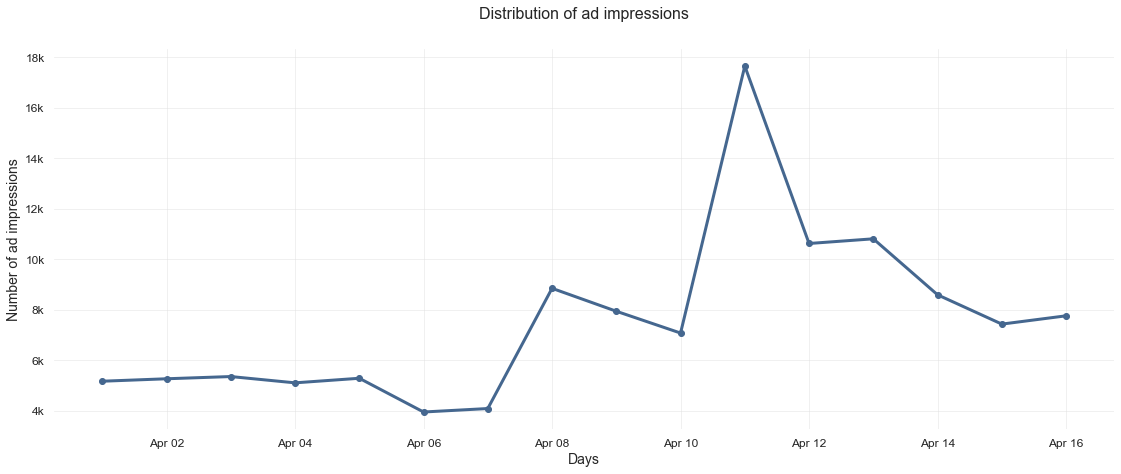

In [130]:
daily_plot(df.drop_duplicates())

A next step would be to localize the problem by splitting the events by various categorical variables and checking whether the anomaly is observable for the certain groups.

From the plots we can see that number of views started to increase from April 8, and reached its highest point on April 11. In particular:
1. **Event type:** number of clicks & reports did not change much, the increase is observable for views
2. **Payment type:** only for CPC
3. **Has video:** increased for ads without videos
4. **Platform:** mostly for Android, with small fluctuation for others

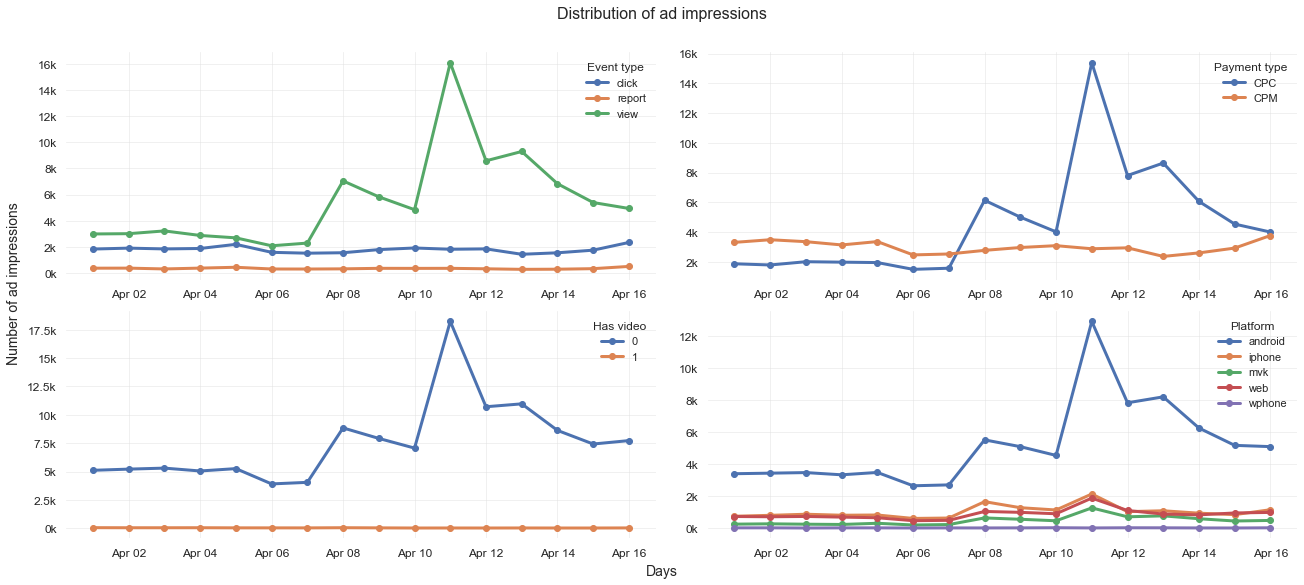

In [131]:
cols_to_plot = ['event', 'ad_cost_type', 'has_video', 'platform']

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.15)
fig.suptitle('Distribution of ad impressions', fontsize=16)

for ax, col, leg in zip(axes.flatten(), cols_to_plot, ['Event type', 'Payment type', 'Has video', 'Platform']):
    daily_plot(df, col, ax=ax)
    ax.set(xlabel='', ylabel='', title='')
    ax.legend(title=leg, loc='upper right', framealpha=0)
    
fig.text(0.00, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=14)
fig.text(0.5, 0.00, 'Days', va='center', ha='center', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Well, maybe people just started to post more advertisements? Or maybe the something happened to one particular ad? It is logical to assume that the problem may be caused by something specific, as the problem is not due to duplicates.

First, let's take the **top 5 agencies by the number of actions** for each day:

In [132]:
top_agency_ids = (df.groupby(['date', 'agency_union_id']).size().sort_values(ascending=False)
                  .groupby('date').head(5).reset_index(name='cnt').sort_values(by='date'))
top_agency_ids.head(11) # ура работает

,date,agency_union_id,cnt
59,2019-04-01,agency_2,88
29,2019-04-01,agency_33,219
26,2019-04-01,agency_158,256
10,2019-04-01,no_agency,3339
45,2019-04-01,agency_70,120
32,2019-04-02,agency_33,190
30,2019-04-02,agency_158,199
47,2019-04-02,agency_2,115
8,2019-04-02,no_agency,3435
53,2019-04-02,agency_70,94


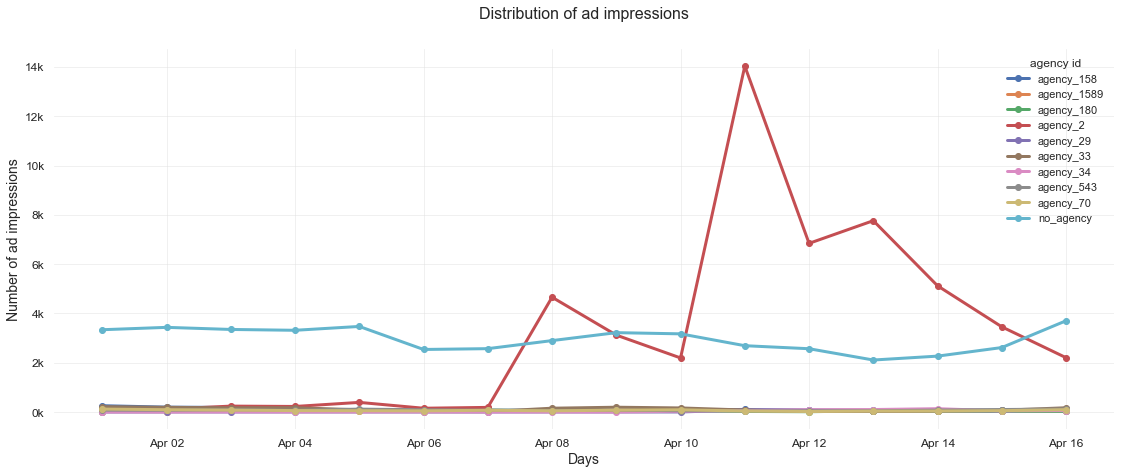

In [133]:
daily_plot(df.query('agency_union_id in @top_agency_ids.agency_union_id'), group_var='agency_union_id', group_title='agency id')

What do we have here?

- Prior to **April 8**, most impressions were related to advertisements **without an agency** (turquoise line)
- From **April 8 to April 15** *(except 9th & 10th)* **agency_2** had the most actions
- **Peak:** April 11

Interesting.


![](https://pp.userapi.com/c851436/v851436067/121512/g4PX3c3gj5s.jpg)



Let's take a closer look at the charts for **Agency 2**. The following plots almost duplicate the previous group of four for the full dataset.

1. **Distribution of events:** quite similar to the original plot, the peak is visible;
2. **Depending on the event type:** sharp increase in views, number of clicks did not change; 
3. **CPC/CPM:** CPC, i.e. cost-per-click  
4. **Platform:** mostly form Android 

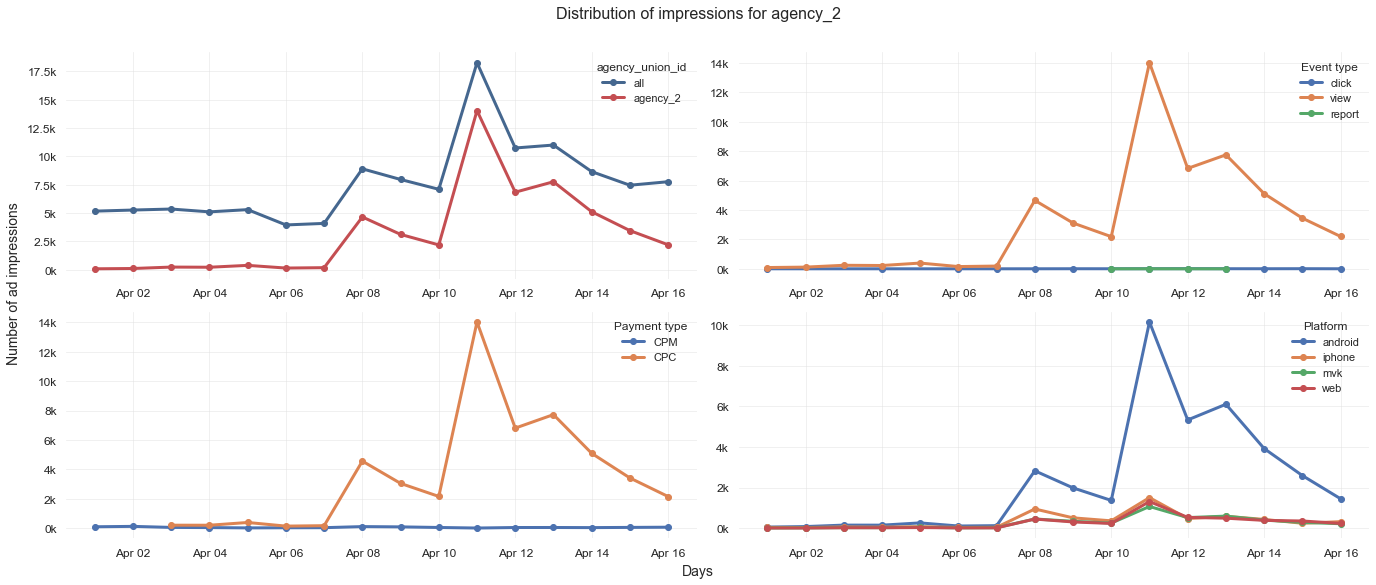

In [134]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(19, 8))
fig.suptitle('Distribution of impressions for agency_2\n', fontsize=16)

daily_plot(df, ax=axes.flatten()[0])
daily_plot(df.query('agency_union_id=="agency_2"'), ax=axes.flatten()[0], color='r')
axes.flatten()[0].legend(('all', 'agency_2'), title='agency_union_id', loc='best', framealpha=0)
axes.flatten()[0].set(xlabel='', ylabel='', title='')

for ax, col, leg in zip(axes.flatten()[1:], ['event', 'ad_cost_type', 'platform'], ['Event type', 'Payment type', 'Platform']):
    daily_plot(df.query('agency_union_id=="agency_2"'), col, ax=ax)
    ax.set(xlabel='', ylabel='', title='')
    ax.legend(title=leg, loc='upper right', framealpha=0)
    
fig.text(0.00, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=14)
fig.text(0.5, 0.00, 'Days', va='center', ha='center', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Okay, seems like the problem is with agency 2. Was it one ad, several, or something else that caused the increase?

In [135]:
# top-3 ads per day by number of impressions
top_per_day = (df.groupby(['date', 'agency_union_id', 'client_union_id', 'campaign_union_id', 'ad_id']).size()
               .sort_values(ascending=False).groupby('date').head(3)
               .reset_index(name='cnt').sort_values(by='date'))
top_per_day.head()

,date,agency_union_id,client_union_id,campaign_union_id,ad_id,cnt
23,2019-04-01,no_agency,client_48,campaign_7701,ad_7701,197
35,2019-04-01,agency_33,client_99583,campaign_99643,ad_99643,102
37,2019-04-01,agency_158,client_106190,campaign_106256,ad_106256,78
39,2019-04-02,agency_2,client_47296,campaign_97294,ad_97427,73
38,2019-04-02,agency_33,client_99583,campaign_99643,ad_99643,76


In [136]:
# keep ads that have num. of impressions > average
#med_cnt = np.median(top_per_day.cnt)
mean_cnt = np.mean(top_per_day.cnt)
strange_ads = (top_per_day.sort_values(by=['cnt'], ascending=False)
               .query('cnt > @ mean_cnt').ad_id.unique())
strange_ads

array(['ad_49554', 'ad_49556', 'ad_49560', 'ad_49564'], dtype=object)

Let's look at the aggragated metrics for each ad (not by day but for the entire period):

1. In total there are four suspicious ads
2. All of them are from **agency_2** → **client_47270** → **campaign_49554**
3. Type: CPC
4. A lot of views, but almost no clicks at all → CTR is also low
5. Highest number of impressions – among Android users


In [137]:
(df.query('ad_id in @strange_ads')
 .groupby(['ad_id','event','platform','ad_cost_type','agency_union_id', 'client_union_id', 'campaign_union_id'])
 .size().reset_index(name='cnt')
 .pivot_table(index=['agency_union_id','client_union_id', 'campaign_union_id','ad_id','ad_cost_type',], columns=['event','platform'], values='cnt')
 .reset_index().fillna(0))

event    agency_union_id client_union_id campaign_union_id     ad_id  \
platform                                                               
0               agency_2    client_47270    campaign_49554  ad_49554   
1               agency_2    client_47270    campaign_49554  ad_49556   
2               agency_2    client_47270    campaign_49554  ad_49560   
3               agency_2    client_47270    campaign_49554  ad_49564   

event    ad_cost_type   click              report            view          \
platform              android iphone  web android iphone  android  iphone   
0                 CPC    23.0    2.0  6.0     4.0    1.0  21015.0  2194.0   
1                 CPC     2.0    0.0  1.0     0.0    0.0   6080.0   804.0   
2                 CPC     5.0    0.0  1.0     1.0    0.0   4888.0  1247.0   
3                 CPC     3.0    0.0  2.0     0.0    0.0   2642.0   718.0   

event                     
platform     mvk     web  
0         2154.0  2101.0  
1          526.0   805.0  
2          708.0   646.0  
3          532.0   594.0

In [138]:
# full table for agency 2
(df.query('agency_union_id == "agency_2"')
 .groupby(['ad_id','event','platform','ad_cost_type','agency_union_id', 'client_union_id', 'campaign_union_id'])
 .size().reset_index(name='cnt')
 .pivot_table(index=['agency_union_id','client_union_id', 'campaign_union_id','ad_id','ad_cost_type',], columns=['event','platform'], values='cnt')
 .reset_index().fillna(0))

event    agency_union_id client_union_id campaign_union_id     ad_id  \
platform                                                               
0               agency_2    client_47269    campaign_47269  ad_47269   
1               agency_2    client_47269    campaign_47279  ad_49136   
2               agency_2    client_47270    campaign_49554  ad_49554   
3               agency_2    client_47270    campaign_49554  ad_49556   
4               agency_2    client_47270    campaign_49554  ad_49560   
5               agency_2    client_47270    campaign_49554  ad_49564   
6               agency_2    client_47270    campaign_49554  ad_50872   
7               agency_2    client_47296    campaign_97293  ad_97293   
8               agency_2    client_47296    campaign_97294  ad_97427   
9               agency_2    client_47296    campaign_97296  ad_97784   
10              agency_2    client_47296    campaign_97299  ad_97803   
11              agency_2    client_47296    campaign_97306  ad_97944   
12              agency_2    client_47296    campaign_97307  ad_97994   
13              agency_2    client_47296    campaign_98057  ad_98057   
14              agency_2    client_98042    campaign_98060  ad_98060   
15              agency_2    client_98052    campaign_98061  ad_98061   
16              agency_2    client_98053    campaign_98063  ad_98063   
17              agency_2    client_98058    campaign_98064  ad_98064   

event    ad_cost_type   click              report            view          \
platform              android iphone  web android iphone  android  iphone   
0                 CPC     0.0    1.0  0.0     0.0    0.0   1164.0   370.0   
1                 CPC     0.0    0.0  0.0     0.0    0.0    290.0    77.0   
2                 CPC    23.0    2.0  6.0     4.0    1.0  21015.0  2194.0   
3                 CPC     2.0    0.0  1.0     0.0    0.0   6080.0   804.0   
4                 CPC     5.0    0.0  1.0     1.0    0.0   4888.0  1247.0   
5                 CPC     3.0    0.0  2.0     0.0    0.0   2642.0   718.0   
6                 CPC     0.0    0.0  0.0     0.0    0.0     22.0     5.0   
7                 CPM     0.0    0.0  0.0     0.0    0.0     79.0    33.0   
8                 CPM     0.0    0.0  0.0     0.0    0.0    214.0   103.0   
9                 CPM     0.0    0.0  0.0     0.0    0.0     12.0     4.0   
10                CPM     0.0    0.0  0.0     0.0    0.0     93.0    38.0   
11                CPM     0.0    0.0  0.0     0.0    0.0     30.0    12.0   
12                CPM     0.0    0.0  0.0     0.0    0.0     34.0    22.0   
13                CPM     2.0    1.0  0.0     0.0    0.0      0.0     0.0   
14                CPM     1.0    0.0  0.0     0.0    0.0      0.0     0.0   
15                CPM     2.0    0.0  0.0     0.0    0.0      0.0     0.0   
16                CPM     0.0    1.0  0.0     0.0    0.0      0.0     0.0   
17                CPM     1.0    0.0  0.0     0.0    0.0      0.0     0.0   

event                     
platform     mvk     web  
0          201.0   131.0  
1           28.0    23.0  
2         2154.0  2101.0  
3          526.0   805.0  
4          708.0   646.0  
5          532.0   594.0  
6            4.0     3.0  
7           17.0     5.0  
8           24.0    16.0  
9            2.0     1.0  
10          10.0     0.0  
11           7.0     1.0  
12           5.0     2.0  
13           0.0     0.0  
14           0.0     0.0  
15           0.0     0.0  
16           0.0     0.0  
17           0.0     0.0

Based on the first plot, we can conclude that without strange advertisements, the original graph looks quite normal (gray line).

The second plot shows the number of ad impressions for the **client_47270** that owns these 4 ads, also grouped by ad campaign id. Apparently, this client did not have any other ads as the stats starts from the same day, and the client has only one campaign id.

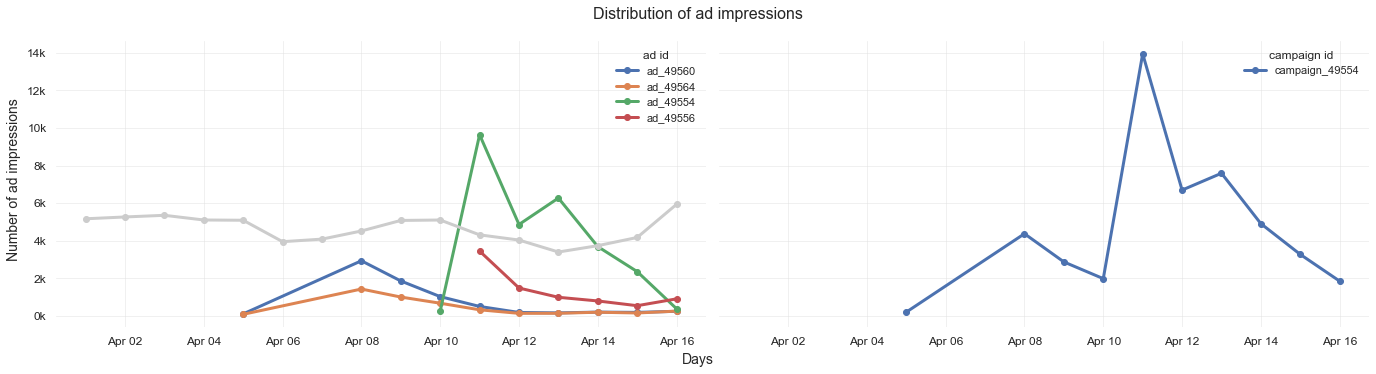

In [139]:
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(19,5))
fig.subplots_adjust(hspace=0.4, wspace=0.15)
fig.suptitle('Distribution of ad impressions', fontsize=16)
daily_plot(df.query('ad_id in @strange_ads'), group_var='ad_id', group_title='ad id', ax=axes.flatten()[0])
daily_plot(df.query('ad_id not in @strange_ads'), ax=axes.flatten()[0], color='#cccccc')
daily_plot(df.query('client_union_id == "client_47270"'), group_var='campaign_union_id', group_title='campaign id',
           ax=axes.flatten()[1])
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='', title='')
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical'
         , va='center', ha='center', fontsize=14)
fig.text(0.5, 0.0, 'Days', va='center', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

This means that the problem is not in the agency 2 itself, but in its **particular advertising campaign**. If you look at the statistics for this agency, you will notice that there are other ads & campaigns with no anomalies.

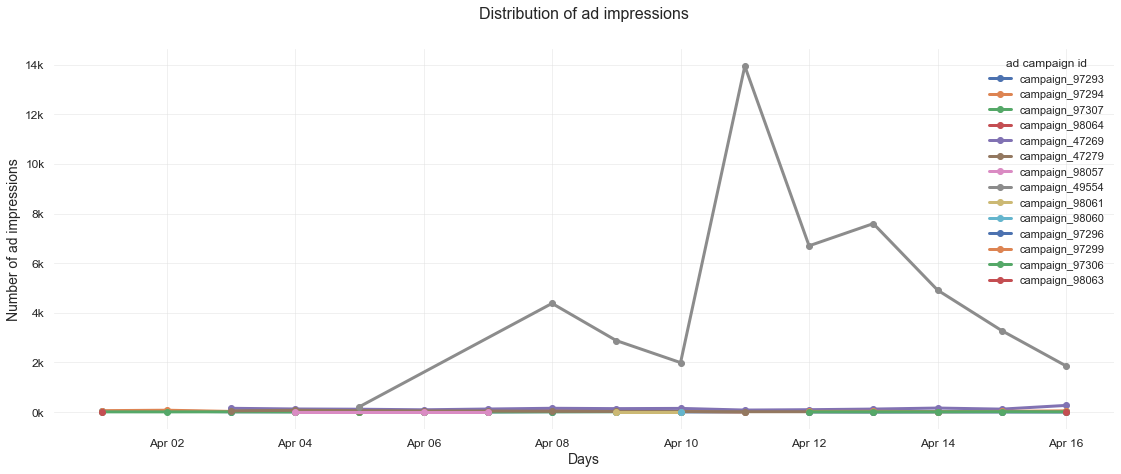

In [140]:
daily_plot(df.query('agency_union_id == "agency_2"'), group_var='campaign_union_id', group_title='ad campaign id')

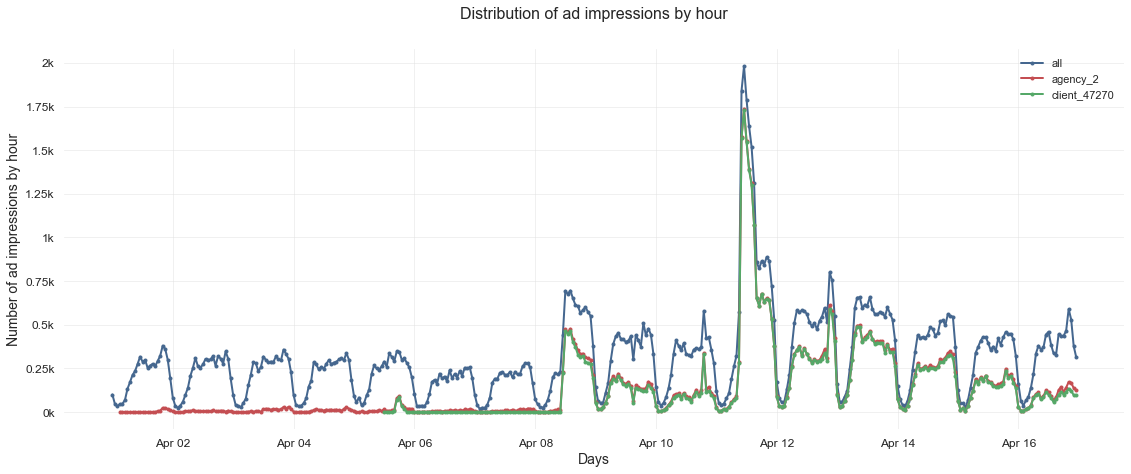

In [141]:
# distribution by hour seems to be ok (similar to the general pattern)
df_hourly = df.resample(rule='H').count()
df_hourly_ag2 = df.query('agency_union_id == "agency_2"').resample(rule='H').count()
df_hourly_cl = df.query('client_union_id == "client_47270"').resample(rule='H').count()
fig, ax = plt.subplots()
ax.plot(df_hourly.index, df_hourly.event, color='#45678f', linewidth=2, markersize=3, marker='o')
ax.plot(df_hourly_ag2.index, df_hourly_ag2.event, color='r', linewidth=2, markersize=3, marker='o')
ax.plot(df_hourly_cl.index, df_hourly_cl.event, color='g', linewidth=2, markersize=3, marker='o')
ax.legend(('all', 'agency_2', 'client_47270'), title='',loc='best', framealpha=0)
ax.set(xlabel='Days', ylabel='Number of ad impressions by hour', title='Distribution of ad impressions by hour')
ax.set_frame_on(False)
ax.yaxis.set_major_formatter(FuncFormatter( lambda y, p: '{:,g}k'.format(y/1000) ))
ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))
plt.grid(True, color='#e2e2e2', alpha=0.5)

## Conclusions

So, what happened? There are several main hypotheses & conclusions:
1. Most likely, **no errors** occurred during the data collection stage. There are very few duplicates, and the overall picture does not change when they are removed. If something broke / stopped collecting, then it would have been noticeable: for example, set to 0, or this problem would have affected more ads. Here the anomaly is observable only for one campaign of a particular agency.
2. Clickbait did not take place as the number of impressions increased, but not the clicks. More precisely, there are almost no clicks at all.
3. The only option remains: **incorrect advertising settings**. There are  quite a lot of impressions – it means that the advertisement was shown to some users. But there are almost no clicks, therefore, users are not interested in this ad. There are also very few reports, so everything should be fine with the ad text itself *(+ they are also being moderated)*. The type of payment is CPC, i.e. per click, not impressions, so the client himself did not suffer that much c:


In order to investigate the anomaly in more detail, it would be nice to look at the target settings, the place where the ads were displayed (feed / recommendations / other) and, possibly, on the ads themselves. And users who saw the ad – were they real?
***

## 3. anomaly detection.
***Task (optional):*** *Suggest a way that would help to automatically detect abnormal changes in metrics on advertising statistics charts.*

- *Suggest an algorithm that analyses data for the past day every morning, and if it is out of the general trend, sends a notification to the analyst: there is a problem on this chart for yesterday*
- *Think about how to make a detector that checks for anomalies every hour, every five minutes?*
- *Suggest a version of the code that solves this problem. It is not necessary to implement the logic of the notification, only the search for an abnormal day, hour, or five minutes in the advertising statistics data.*

***


![](https://pp.userapi.com/c850728/v850728351/11f837/IeTmf9FDOwU.jpg)  

### Moving Average & CI



One of the possible and simple ways: calculate the moving average in order to smooth the trend, build confidence intervals, and if the value goes beyond it, consider it as anomaly. In general, this method is based on the assumption that the latter value depends on the mean $n$ previous observations. This method is not always suitable if there are some seasonal anomalies, but why not to try it.

$$SMA_t = \frac{1}{n}\sum_{i=0}^{n-1}x_{t-i} = \frac{x_t + x_{t-1} + ... + x_{t-(n-1)}}{n}$$

The `moving_avg` function accepts the initial dataset as input, the window size *(the larger, the more smoothed the line will be)*, then counts the number of advertising events depending on the specified period *(by hours, minutes, etc.)*, and further calculates a moving average. Then an interval is built *(taking into account the `score` & `bound_param` parameters)*, and if some observations go beyond its boundaries, then they are considered anomalies. You can also display a plot *(all / obs. signs / trend, below there are some examples)*.

As you will see later, this method works well if you choose the right window, resampling rule, and confidence interval. The plots and thoughts  are described below :)



Simple code for the moving average:

In [142]:
def moving_average(data, window=5):
    """
    Moving average.
    """
    wndw = np.ones(int(window))/float(window)
    rolling_mean = np.convolve(data, wndw, 'valid')

    return rolling_mean

In [143]:
df_hourly = df.resample(rule='H').size()

In [144]:
%%time
moving_average(df_hourly, 2)[:5]

CPU times: user 363 µs, sys: 30 µs, total: 393 µs
Wall time: 381 µs


array([73. , 39.5, 39.5, 46.5, 58. ])

But `pandas` has its own implementation, so I'm gonna use it.

In [145]:
%%time
df_hourly.rolling(window=2).mean().head(3)

CPU times: user 1.97 ms, sys: 119 µs, total: 2.09 ms
Wall time: 2.23 ms


date_time
2019-04-01 00:00:00     NaN
2019-04-01 01:00:00    73.0
2019-04-01 02:00:00    39.5
Freq: H, dtype: float64

In [146]:
def moving_avg(data, resample_rule='H', window=2, plot=False, score=1.96, ax=None, 
               bounds='both', bound_param='r--', obs=True, trend=True, day=None, extended=False):
    """Searches anomalies based on moving average and confidence intervals.
    
    Parameters
    ---------
    data: pandas DataFrame
        DataFrame
    resample_rule: str
        Resampling rule (e.g. 'H' – hours, 'D' – days)
    window: int
        Window size.
    plot: bool, optional
        True, if plot output.
    scale: float, optional
        Z-score for confidence interval.
    ax: axis, optional
        Axis object if it's already present (useful for plotting several graphs at once).
    bounds: str
        Plot upper or both interval bounds. 
    bound_param: str, optional
        Confidence intervals line color and type.
    obs: bool, optional
        True, if plot observed values.
    trend: bool, optional
        True, if plot trend line (moving average). 
    day:
        Day for the detailed statistics. 
    extended:
        True, if print the list of anomalies.
    """
    
    data_res = pd.DataFrame(data.resample(rule=resample_rule).size(), columns=['cnt'])
    rolling_mean = data_res.rolling(window=window).mean()

    # confidence intervals
    # two bounds – for too high & small values
    std = np.std(data_res[window:] - rolling_mean[window:])
    lower_bound = rolling_mean - (score * std)
    upper_bound = rolling_mean + (score * std)

    # searching for anomalies
    anomalies = pd.DataFrame(index=data_res.index, columns=data_res.columns)
    anomalies[data_res < lower_bound] = data_res[data_res < lower_bound]
    anomalies[data_res > upper_bound] = data_res[data_res > upper_bound]
    
    # plotting it
    if plot:
        if ax is None:        
            fig, ax = plt.subplots()  
        if obs:
            ax.plot(data_res[window:], label='observed', color='#45678f')
        if trend:
            ax.plot(rolling_mean, 'g', label='trend')
        if bounds == 'both':
            ax.plot(upper_bound, bound_param, label='bounds')
            ax.plot(lower_bound, bound_param)
        elif bounds == 'upper':
            ax.plot(upper_bound, bound_param, label='upper bound')
            anomalies = pd.DataFrame(index=data_res.index, columns=data_res.columns)
            anomalies[data_res > upper_bound] = data_res[data_res > upper_bound]
        ax.plot(anomalies, 'ro', markersize=7, label = 'anomaly')
        ax.set_frame_on(False)
        ax.yaxis.set_major_formatter(FuncFormatter( lambda y, p: '{:,g}k'.format(y/1000)))
        ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))    
        #ax.axes.set_ylim(bottom=0)  # bound can be lower than 0 sometimes 
        ax.set(xlabel='Days', ylabel='Number of ad impressions', 
               title='Moving average\nwindow: {}, resample: {}, score: {}'.format(window, resample_rule, score))
        ax.legend(loc='best', framealpha=0)
        ax.grid(True, color='#e2e2e2', alpha=0.5)
    
    # print notification
    return anomaly_alert(anomalies, day, extended)

In [147]:
def anomaly_alert(anomalies, day, extended):
    if day: 
        anomalies_count = anomalies[day:day].count().values[0]
    else:
        anomalies_count = anomalies.count().values[0]
    
    if anomalies_count > 0:
        print('Day: {}\nSomething went wrong, it\'s time to check the plots.\nAnomalies Found: {}\n'.format(day if day else 'entire selected period', anomalies_count))
        if extended:
            print(anomalies[day:day].dropna() if day else anomalies.dropna())
    else:
        print('Day: {}\nEverything is ok!'.format(day if day else 'entire selected period'))

### how it works
#### Daily

Since the task is to find **anomalies** in the data for **the past day**, let's take the data for April 11 and 10 *(i.e., compare the statistics for the selected day with the previous one)*, as well as for 9th, as if we take observations for only two days *(aggregate by day)*, then there will be nothing to compare *(NaN & one value)*. So, it means that you need to take data for the selected day and two previous preceding.

In [148]:
df['2019-04-09':'2019-04-11'].resample('D').count().rolling(window=2).mean()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
date_time,,,,,,,,,,
2019-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-10,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5
2019-04-11,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5


**Example:** data from April 1 to April 11, aggregated by day. Anomalies for April 11 are found.

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 1

              cnt
date_time        
2019-04-11  18259


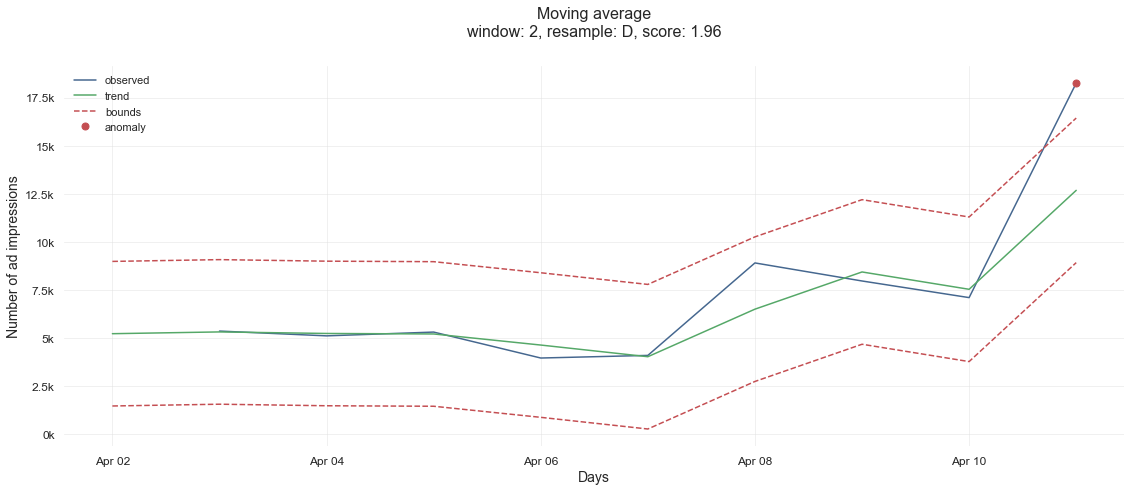

In [149]:
moving_avg(df['2019-04-01':'2019-04-11'], resample_rule='D', plot=True, window=2, extended=True)

#### Hourly

Let's take a look how the function works with different window sizes (2, 6, 24, 48) for the entire period.

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 15

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 16

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 13

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 12



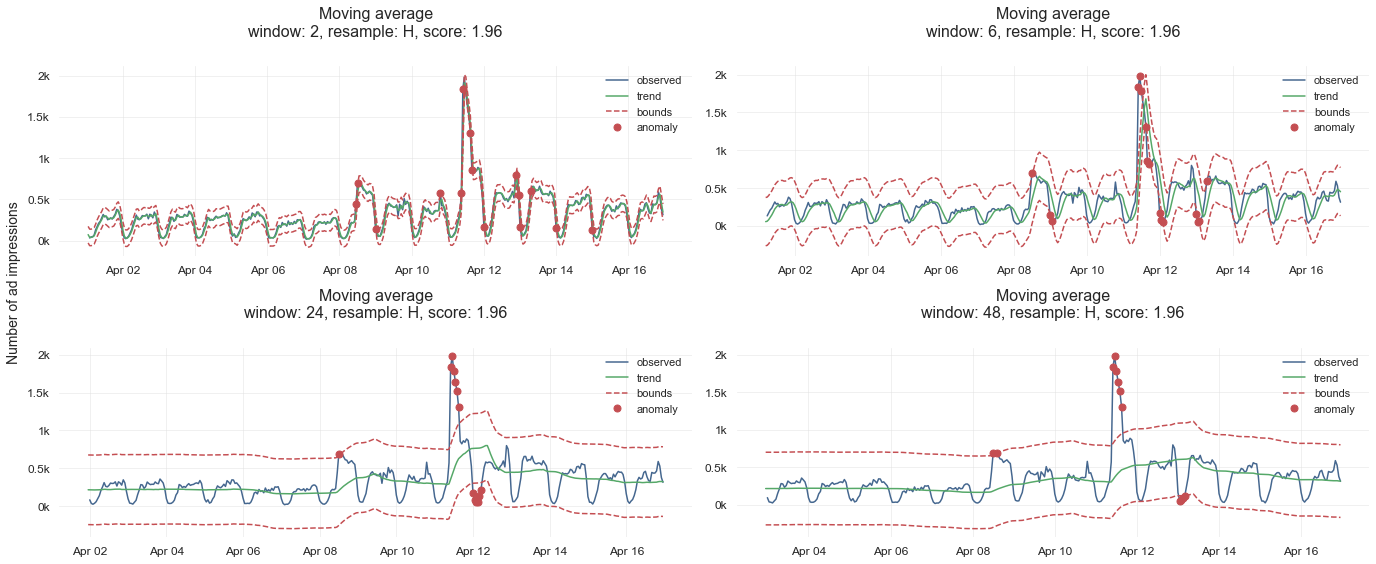

In [150]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(19,8))
for ax, window in zip(axes.flatten(), [2, 6, 24, 48]):
    moving_avg(df, resample_rule='H', window=window, plot=True, ax=ax)
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=14)
plt.tight_layout()
plt.show()


And now for April 10-11. Based on the plots and text outputs, you can see that anomalies were detected, and a sharp increase occurred approximately at 10 am on 11.04.

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 2

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 3



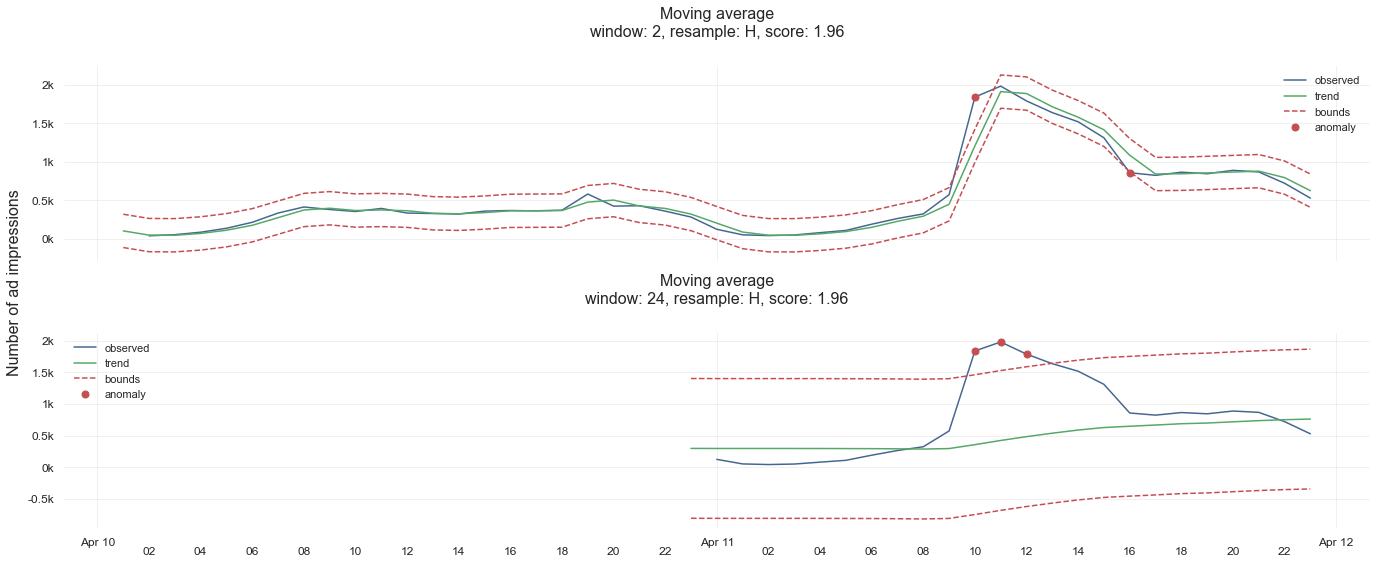

In [151]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 8), sharex=True)
# hourly data for April 10-11 
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=2, plot=True, ax=axes.flatten()[0])
# window size 24 hours = 1 day
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=axes.flatten()[1])
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 2)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H')) 
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

Same for April 8:

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 4

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 3



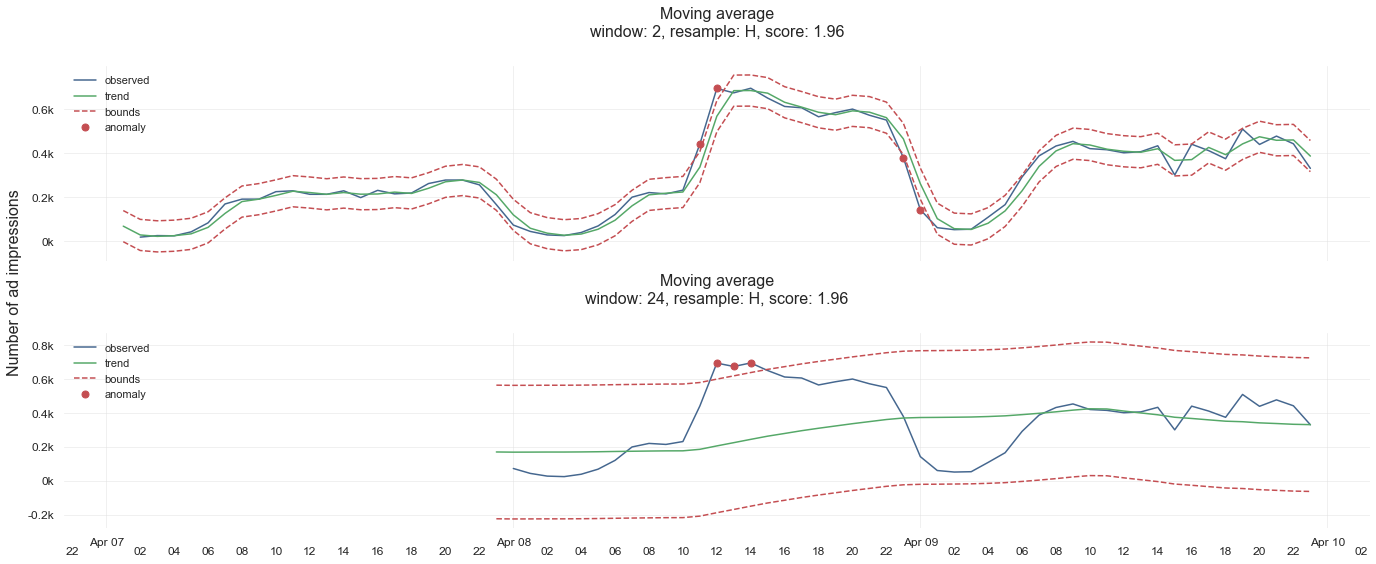

In [152]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 8), sharex=True)
# 3-day period, window size 2
moving_avg(df['2019-04-07':'2019-04-09'], resample_rule='H', window=2, plot=True, ax=axes.flatten()[0])
# window size 24 hours
moving_avg(df['2019-04-07':'2019-04-09'], resample_rule='H', window=24, plot=True, ax=axes.flatten()[1])
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 2)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H')) 
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

Also we can use different `score` values to plot the confidence intervals. The larger the value, the wider the interval will be.
- blue lines represent CI with a score = 1.282
- red lines – standard CI with a score = 1.96
- green lines – CI with a score = 2.576

5, 3 and 2 anomalies were detected respectively.

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 5

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 3

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 2



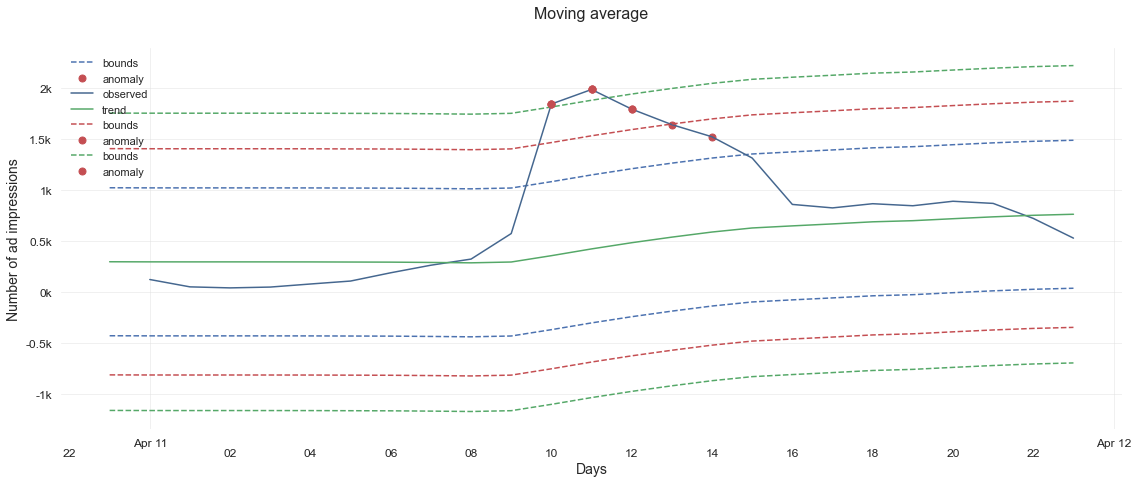

In [153]:
fig, ax = plt.subplots()
# previous & current day
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=ax, score=1.282, 
           bound_param='b--', obs=False, trend=False)
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=ax)
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=ax, score=2.576, 
           bound_param='g--', obs=False, trend=False)

ax.set(title='Moving average')
ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 2)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H'))   

#### 5 minutes
At first I thought the method is suitable for **5-min intervals** only if you use many previous periods. In cases where there are only a few of them, anomalies are not detected.

There is an obvious drawback: if we compare very close periods *(only several 5-min ones)*, the algorithm does not find anomalies, since the obtained values do not go beyond the interval. In this case, setting different parameters for the CI helps. In general, it does not seem very logical to compare a small number of intervals, especially short ones: the increase in the number of impressions occurred gradually, and, more precisely, not sharply enough to be detected.
So ---> just use more data

**But** after all, the point is just to check if everything is good with the data every 5 minutes, and not to compare small intervals. It turns out that if you aggregate the data for 5 minutes, and then calculate the necessary metrics based on data, for instance, for the previous day *(also divided into 5-min intervals)*, then it will work fine.


Day: entire selected period
Everything is ok!
Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 6



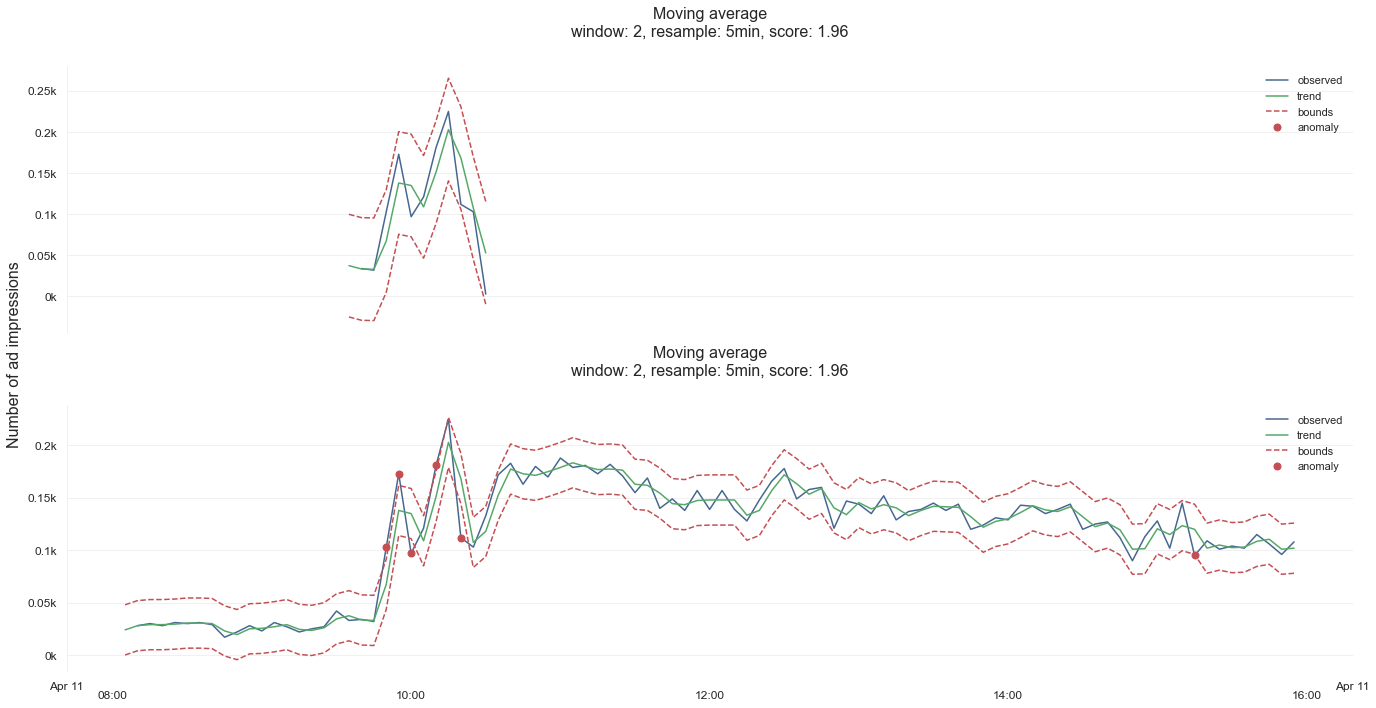

In [154]:
fig, axes = plt.subplots(nrows=2, figsize=(19,10), sharex=True)
# select 1 hour where we had anomalies, split into 5-min intervals, set window size to 2 --> doesnt work
moving_avg(df['2019-04-11 09:30:00':'2019-04-11 10:30:00'], resample_rule='5min', window=2, plot=True, 
           ax=axes.flatten()[0])
# take a wider interval, where we also had some anomalies --> works
moving_avg(df['2019-04-11 08:00:00':'2019-04-11 16:00:00'], resample_rule='5min', window=2, plot=True, ax=axes.flatten()[1])
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 2)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H:%M')) 
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

#### confidence intervals parameters

Let's also take a closer look at the parameters of the intervals. At a 99% confidence interval, there are fewer anomalies: only the main ones. 
Anomalies were detected for April 8, when the increase just started, and for April 11. 

Possible Cons: there are some false positives. At some point, the algorithm considers smaller values *(night, April 12)* as anomalies.

Note: the 'day' parameter is not used here yet

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 176

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 117



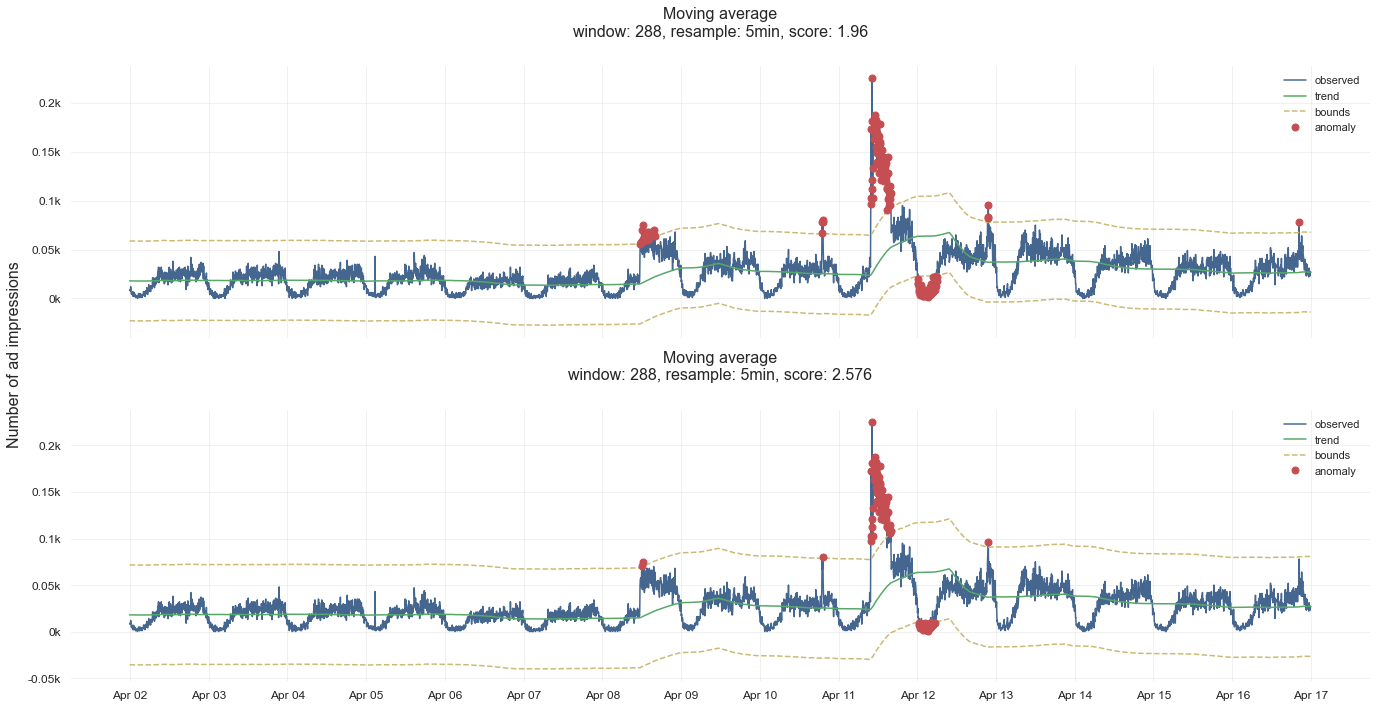

In [155]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True)
# yellow lines 
moving_avg(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[0], bound_param='y--')  
moving_avg(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[1], score=2.576, bound_param='y--')  # 99%
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()


Alternatively, you can search only for those anomalies that are above the upper boundary (`bounds = 'upper'`):


Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 71



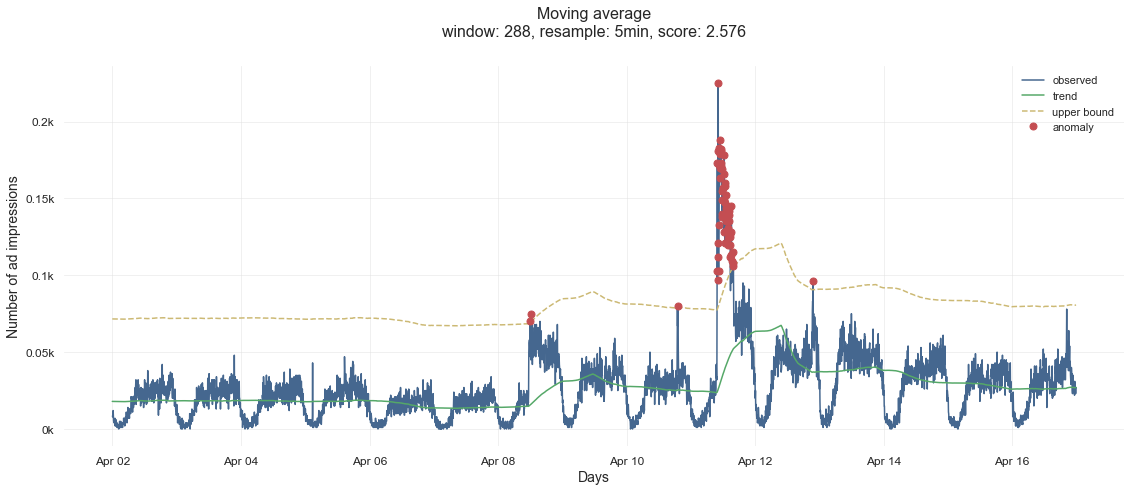

In [156]:
fig, ax = plt.subplots() 
moving_avg(df, resample_rule='5min', window=24*60//5, plot=True, ax=ax, score=2.576, bound_param='y--', bounds='upper')
plt.show()

**Small conculsion:** moving average approach works.
***

### Moving Median

We can also use the median instead of the mean, which works better for 5-minute intervals with wider CI.

In [157]:
def moving_med(data, resample_rule='H', window=2, plot=False, score=1.96, ax=None, bound_param='r--', 
               obs=True, trend=True, day=None, extended=False):
    """Moving median.
    
    Parameters
    ---------
    data: pandas DataFrame
        DataFrame
    resample_rule: str
        Resampling rule (e.g. 'H' – hours, 'D' – days)
    window: int
        Window size.
    plot: bool, optional
        True, if plot output.
    scale: float, optional
        Z-score for confidence interval.
    ax: axis, optional
        Axis object if it's already present (useful for plotting several graphs at once).
    bound_param: str, optional
        Confidence intervals line color and type.
    obs: bool, optional
        True, if plot observed values.
    trend: bool, optional
        True, if plot trend line (moving median). 
    day:
        Day for the detailed statistics. 
    extended:
        True, if print the list of anomalies.
    """
    
    data_res = pd.DataFrame(data.resample(rule=resample_rule).size(), columns=['cnt'])
    rolling_median = data_res.rolling(window=window).median()  # !

    # confidence interval
    std = np.std(data_res[window:] - rolling_median[window:])
    lower_bound = rolling_median - (score * std)
    upper_bound = rolling_median + (score * std)

    # searching for anomalies
    anomalies = pd.DataFrame(index=data_res.index, columns=data_res.columns)
    anomalies[data_res < lower_bound] = data_res[data_res < lower_bound]
    anomalies[data_res > upper_bound] = data_res[data_res > upper_bound]
    
    if plot:
        if ax is None:        
            fig, ax = plt.subplots()  
        if obs:
            ax.plot(data_res[window:], label='observed', color='#45678f')
        if trend:
            ax.plot(rolling_median, 'g', label='trend')
        ax.plot(upper_bound, bound_param, label='bounds')
        ax.plot(lower_bound, bound_param)
        ax.plot(anomalies, 'ro', markersize=7, label = 'anomaly')
        ax.set_frame_on(False)
        ax.yaxis.set_major_formatter(FuncFormatter( lambda y, p: '{:,g}k'.format(y/1000)))
        ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))    
        ax.set(xlabel='Days', ylabel='Number of ad impressions', 
               title='Moving median\nwindow: {}, resample: {}, score: {}'.format(window, resample_rule, score))
        ax.legend(loc='best', framealpha=0)
        ax.grid(True, color='#e2e2e2', alpha=0.5)

    # print notification
    return anomaly_alert(anomalies, day, extended)

This approach works slightly better: the algorithm does not consider that many smaller values as anomalies (April 12).

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 171

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 78



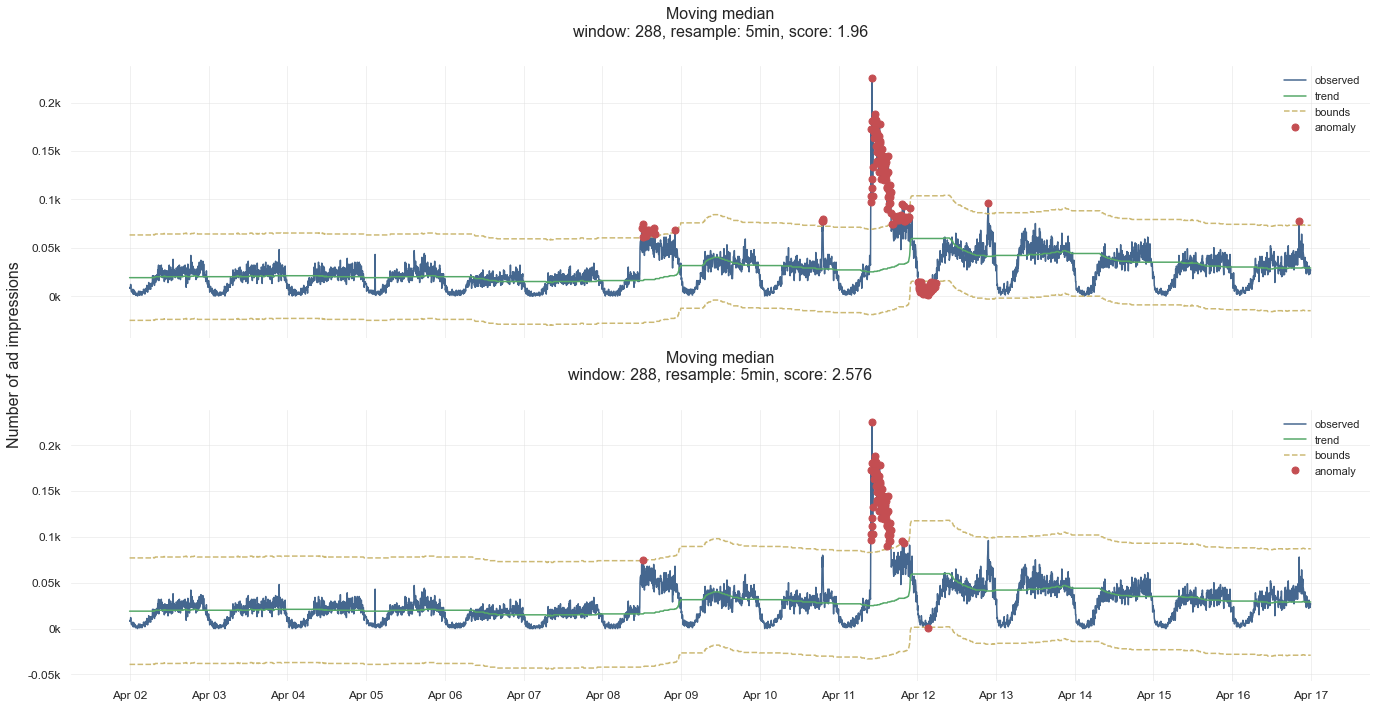

In [158]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True)
moving_med(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[0], bound_param='y--')  
moving_med(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[1], score=2.576, bound_param='y--')  # 99%
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

***

### Exponential Moving Average
And alternatively – exponential moving average.

In [159]:
def EMA(data, resample_rule='H', window=2, plot=False, score=1.96, ax=None, bound_param='r--', 
        obs=True, trend=True, day=None, extended=False):
    """Exponential Moving Average.
    
    Parameters
    ---------
    data: pandas DataFrame
        DataFrame
    resample_rule: str
        Resampling rule (e.g. 'H' – hours, 'D' – days)
    window: int
        Window size.
    plot: bool, optional
        True, if plot output.
    scale: float, optional
        Z-score for confidence interval.
    ax: axis, optional
        Axis object if it's already present (useful for plotting several graphs at once).
    bound_param: str, optional
        Confidence intervals line color and type.
    obs: bool, optional
        True, if plot observed values.
    trend: bool, optional
        True, if plot trend line (moving median). 
    day:
        Day for the detailed statistics. 
    extended:
        True, if print the list of anomalies.
    """
    
    data_res = pd.DataFrame(data.resample(rule=resample_rule).size(), columns=['cnt'])
    exp_ma = data_res.ewm(span=window, adjust=False).mean()  # !

    # confidence interval
    std = np.std(data_res[window:] - exp_ma[window:])
    lower_bound = exp_ma - (score * std)
    upper_bound = exp_ma + (score * std)

    # searching for anomalies
    anomalies = pd.DataFrame(index=data_res.index, columns=data_res.columns)
    anomalies[data_res < lower_bound] = data_res[data_res < lower_bound]
    anomalies[data_res > upper_bound] = data_res[data_res > upper_bound]
    
    if plot:
        if ax is None:        
            fig, ax = plt.subplots()  
        if obs:
            ax.plot(data_res[window:], label='observed', color='#45678f')
        if trend:
            ax.plot(exp_ma, 'g', label='trend')
        ax.plot(upper_bound, bound_param, label='bounds')
        ax.plot(lower_bound, bound_param)
        ax.plot(anomalies, 'ro', markersize=7, label = 'anomaly')
        ax.set_frame_on(False)
        ax.yaxis.set_major_formatter(FuncFormatter( lambda y, p: '{:,g}k'.format(y/1000)))
        ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))    
        ax.set(xlabel='Days', ylabel='Number of ad impressions', 
               title='Exponential Moving Average\nwindow: {}, resample: {}, score: {}'.format(window, resample_rule, score))
        ax.legend(loc='best', framealpha=0)
        ax.grid(True, color='#e2e2e2', alpha=0.5)
    
    # print notification
    return anomaly_alert(anomalies, day, extended)

For comparison: 
1. MA – moving average
2. EMA – exponential moving average

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 117

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 100



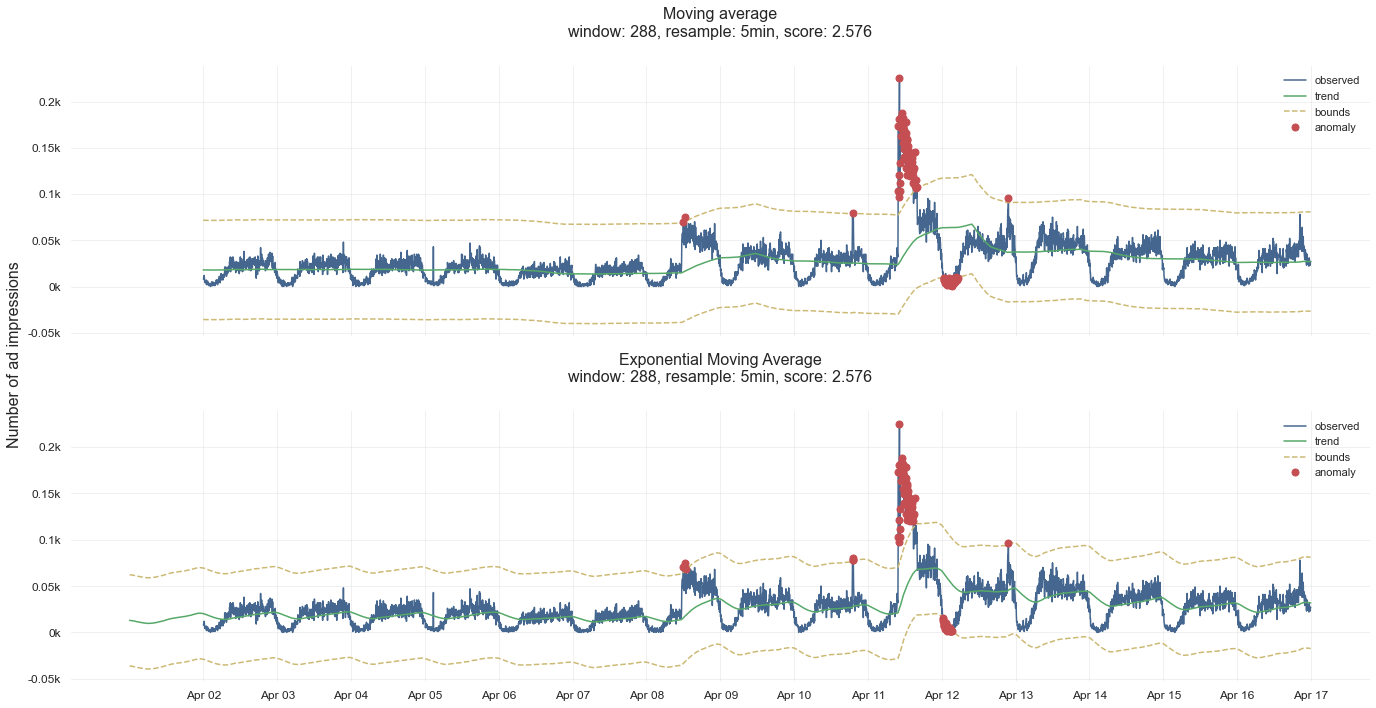

In [160]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True) 
moving_avg(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[0], score=2.576, bound_param='y--')
EMA(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[1], score=2.576, bound_param='y--')

for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

If we take a period of two days (48\* 60/5), both MA and EMA work well. In general, the `window size` and `resampling rule` should be selected based on the time period. For 5-min intervals, 99% CI works well, in other cases – 95% CI also is not bad.

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 74

Day: entire selected period
Something went wrong, it's time to check the plots.
Anomalies Found: 72



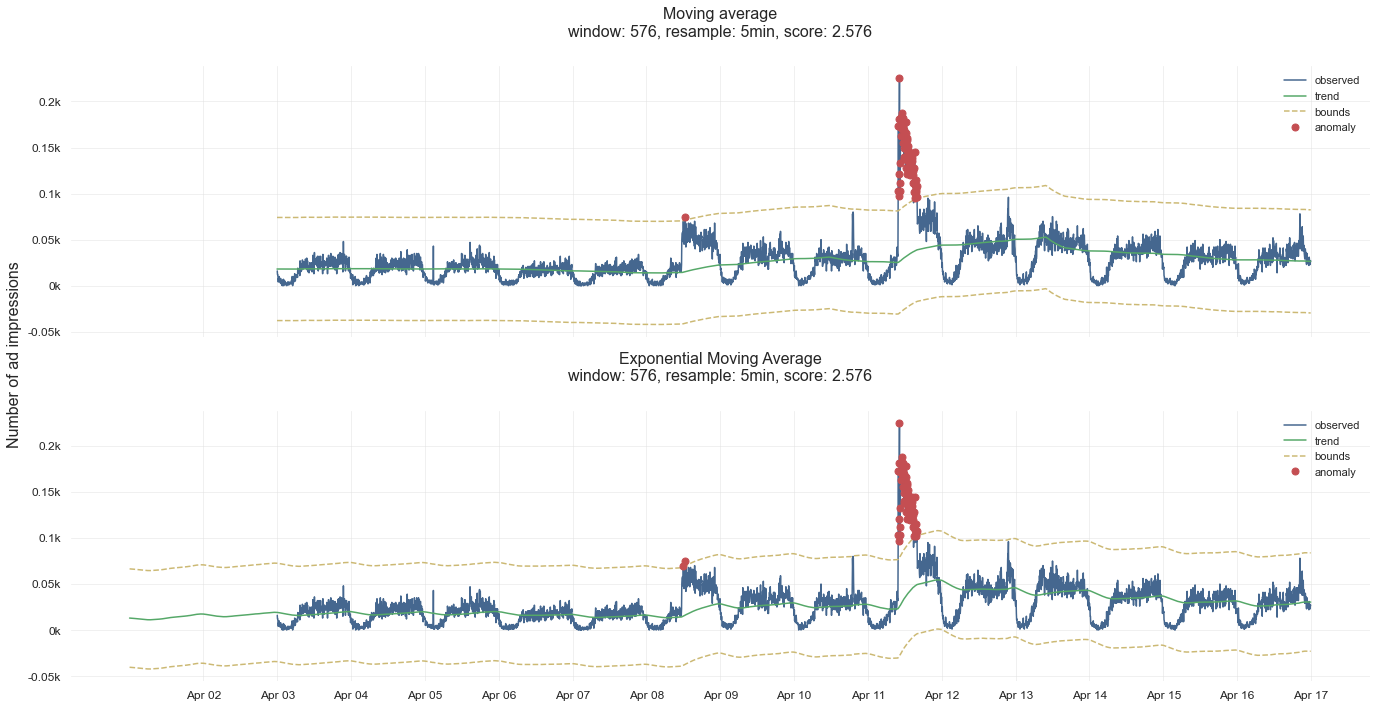

In [161]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True) 
moving_avg(df, resample_rule='5min', window=2*24*60//5, plot=True, ax=axes.flatten()[0], score=2.576, bound_param='y--')
EMA(df, resample_rule='5min', window=2*24*60//5, plot=True, ax=axes.flatten()[1], score=2.576, bound_param='y--')

for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

Usually, if we want to understand whether something happened only on a selected day, we are not really interested in in previous anomalies. So here comes the `day` parameter, which defines the day for which the anomalies should be reported. Example:

1. **Dates:** April 7-11
2. **Selected day:** April 9  
3. **Selected day:** April 11

Day: 2019-04-09
Everything is ok!
Day: 2019-04-11
Something went wrong, it's time to check the plots.
Anomalies Found: 5



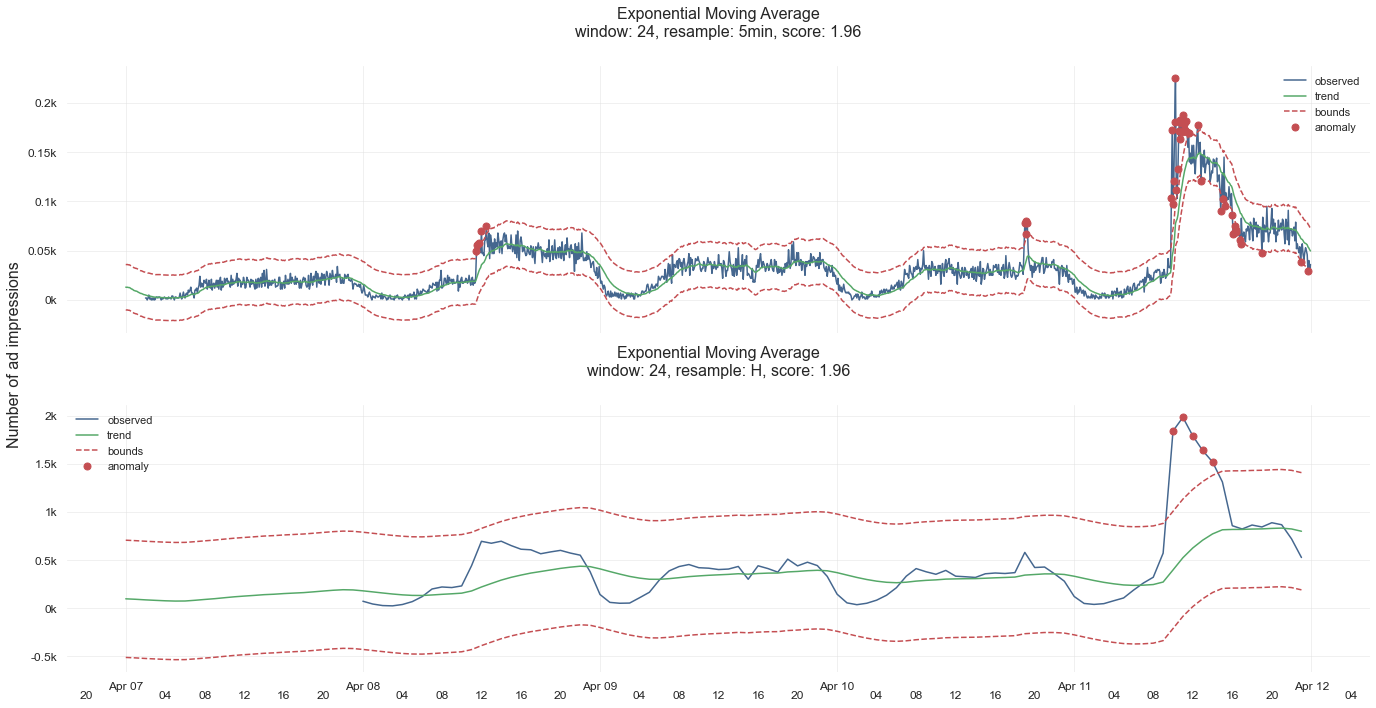

In [162]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True)
# 2019-04-09 
EMA(df['2019-04-07':'2019-04-11'], resample_rule='5min', window=24, plot=True, ax=axes.flatten()[0], day='2019-04-09')
# 2019-04-11
EMA(df['2019-04-07':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=axes.flatten()[1], day='2019-04-11')
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H')) 
fig.text(0.0, 0.5, 'Number of ad impressions', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

And a happy report ending:

Day: 2019-04-16
Everything is ok!


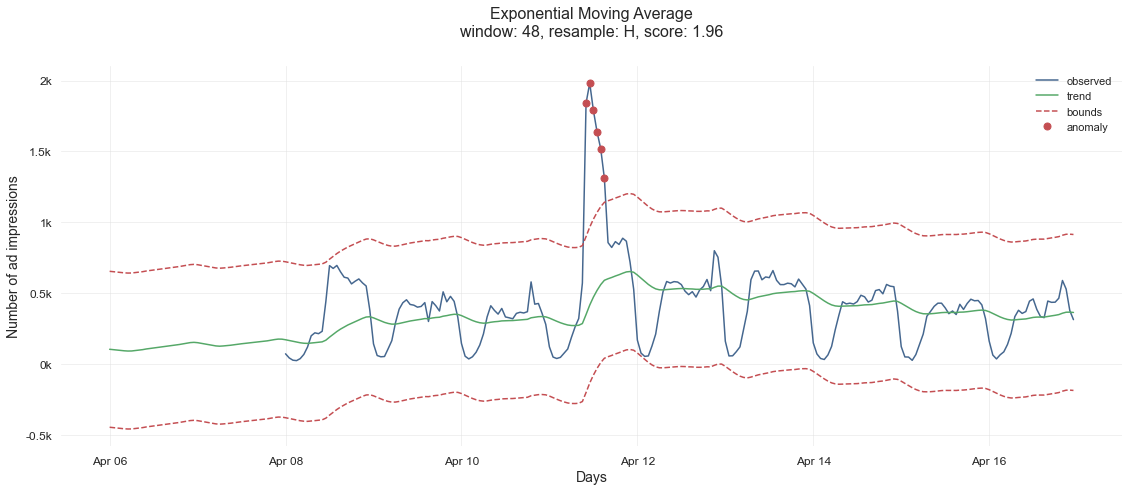

In [163]:
fig, ax = plt.subplots()
EMA(df['2019-04-06':'2019-04-16'], resample_rule='H', window=48, plot=True, ax=ax, day='2019-04-16', extended=True)  

![](https://pp.userapi.com/c856028/v856028527/47871/RnQWzNEyeLc.jpg)